<a href="https://colab.research.google.com/github/ProvenDruid/FFN-projects/blob/main/ffn_missingData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
### import libraries

# for DL modeling
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

import copy
# for number-crunching
import numpy as np
import scipy.stats as stats

# for dataset management
import pandas as pd

# for timing computations
import time

# for data visualization
import matplotlib.pyplot as plt
from IPython import display
from matplotlib_inline.backend_inline import set_matplotlib_formats

In [ ]:
# import the data
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = pd.read_csv(url,sep=';')
data = data[data['total sulfur dioxide']<200] # drop a few outliers
# z-score all columns except for quality
cols2zscore = data.keys()
cols2zscore = cols2zscore.drop('quality')
data[cols2zscore] = data[cols2zscore].apply(stats.zscore)
data['quality'][data['quality']<6]=0
data['quality'][data['quality']>5]=1
dataCopy = copy.deepcopy( data )
whichVals2nan = np.random.choice(len(data),size=10,replace=False)
print(np.sort(whichVals2nan))
data['residual sugar'].iloc[whichVals2nan] = np.nan
print(np.where(data['residual sugar'].isna())[0])
whichValsNotNan = np.where(~data['residual sugar'].isna())[0]

[ 225  413  504  913  979 1111 1276 1295 1456 1513]
[ 225  413  504  913  979 1111 1276 1295 1456 1513]


<ipython-input-198-ba1d0242e6ed>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['quality'][data['quality']<6]=0
<ipython-input-198-ba1d0242e6ed>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['quality'][data['quality']>5]=1
<ipython-input-198-ba1d0242e6ed>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['residual sugar'].iloc[whichVals2nan] = np.nan


In [ ]:
# convert from pandas dataframe to tensor

# vector with residual sugar dropped, for training data
cols2keep = data.keys()
cols2keep = cols2keep.drop('residual sugar')

# extract dataframe to TRAIN tensors
train_dataT  = torch.tensor( data[cols2keep].values ).float()
train_dataT  = train_dataT[whichValsNotNan,:]
train_labelT = torch.tensor( data['residual sugar'].values ).float()
train_labelT = train_labelT[whichValsNotNan,None] # the 'None' is transform to matrix


# same for TEST tensors
test_dataT  = torch.tensor( dataCopy[cols2keep].values ).float()
test_dataT  = test_dataT[whichVals2nan,:]
test_labelT = torch.tensor( dataCopy['residual sugar'].values ).float()
test_labelT = test_labelT[whichVals2nan,None] # the 'None' is transform to matrix

# confirm sizes
print(f'Original data: {data.shape}\n')
print(f'   Train data: {train_dataT.shape}\n')
print(f' Train labels: {train_labelT.shape}\n')
print(f'    Test data: {test_dataT.shape}\n')
print(f'  Test labels: {test_labelT.shape}')

Original data: (1597, 12)

   Train data: torch.Size([1587, 11])

 Train labels: torch.Size([1587, 1])

    Test data: torch.Size([10, 11])

  Test labels: torch.Size([10, 1])


In [ ]:
# then convert them into PyTorch Dataset
train_dataDataset = TensorDataset(train_dataT,train_labelT)

# finally, translate into dataloader objects
batchsize  = 32
train_data = DataLoader(train_dataDataset,batch_size=batchsize,shuffle=True,drop_last=True)

# note: we don't need a TEST dataloader; we'll just pass along the test tensor after training

In [ ]:
# create a class for the model

class ANNwine(nn.Module):
  def __init__(self):
    super().__init__()

    ### input layer
    self.input = nn.Linear(11,16)

    ### hidden layers
    self.fc1 = nn.Linear(16,32)
    self.fc2 = nn.Linear(32,32)

    ### output layer
    self.output = nn.Linear(32,1)

  # forward pass
  def forward(self,x):
    x = F.relu( self.input(x) )
    x = F.relu( self.fc1(x) )
    x = F.relu( self.fc2(x) )
    return self.output(x)

In [ ]:
# a function that trains the model

# global parameter
numepochs = 400

def trainTheModel():

  # loss function and optimizer
  lossfun = nn.MSELoss()
  optimizer = torch.optim.Adam(winenet.parameters(),lr=.01)

  # initialize losses
  trainLoss = torch.zeros(numepochs)

  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    batchLoss = []
    for X,y in train_data:

      # forward pass and loss
      yHat = winenet(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())
    # end of batch loop...

    # get average losses across the batches
    trainLoss[epochi] = np.mean(batchLoss)

  # function output
  return trainLoss

In [ ]:
# create a model and train it
winenet = ANNwine()
trainLoss = trainTheModel()

In [ ]:
# get the predictions for the missing data
yHatTrain = winenet(train_dataT)
yHatTest  = winenet(test_dataT)

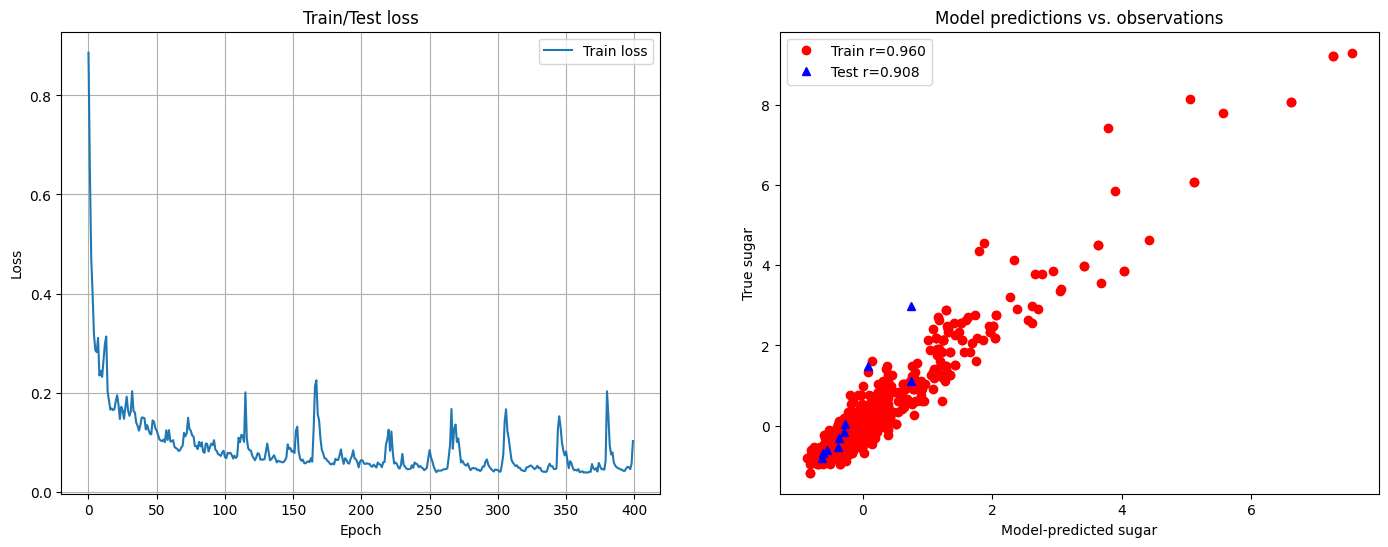

In [ ]:
# plot some results
fig,ax = plt.subplots(1,2,figsize=(17,6))

ax[0].plot(trainLoss,label='Train loss')
ax[0].set_title('Train/Test loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[0].grid()


ax[1].plot(yHatTrain.detach(),train_labelT,'ro')
ax[1].plot(yHatTest.detach(),test_labelT,'b^')
ax[1].set_xlabel('Model-predicted sugar')
ax[1].set_ylabel('True sugar')
ax[1].set_title('Model predictions vs. observations')

# correlations between predictions and outputs
corrTrain = np.corrcoef(yHatTrain.detach().T,train_labelT.T)[1,0]
corrTest  = np.corrcoef(yHatTest.detach().T, test_labelT.T)[1,0]
ax[1].legend([ f'Train r={corrTrain:.3f}',f'Test r={corrTest:.3f}' ])

plt.show()